In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile
from pydub import AudioSegment

In [2]:
import json

data_root = '/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/'
align = json.load(open('align.json'))

In [3]:
import random

# randomly sample 4 audio files
samples = []
for i in range(4):
    samples.append(random.choice(align[str(i)]))

print(samples)

[['IC0966W0479', 'ing1', 1.23, 0.35000000000000003], ['IC0117W0309', 'e2', 1.08, 0.33999999999999997], ['IC0190W0046', 'o3', 0.85, 0.43000000000000005], ['IC0590W0474', 'un4', 3.12, 0.29000000000000004]]


In [4]:
def chop(y, start: float, dur: float, sr=16000, max_dur_len=0.8):
    extra_sec = (max_dur_len - dur) / 2
    s, dur_len, extra_len, L = librosa.time_to_samples([start, dur, extra_sec, max_dur_len], sr=sr)
    ret = np.zeros(L, dtype='float32')

    fade_len = min(extra_len, librosa.time_to_samples(0.025, sr=sr))
    s = max(0, s - fade_len)
    e = s + dur_len + fade_len
    y = y[s:e]

    mask = np.zeros_like(y)
    mask[:fade_len] = np.linspace(0, 1, num=fade_len)
    mask[-fade_len:] = np.linspace(1, 0, num=fade_len)
    mask[fade_len:-fade_len] = 1
    y *= mask
    
    offset = (L - dur_len) // 2 - fade_len
    ret[offset:offset + y.size] = y
    return ret


def specshow(y, sr=16000, ax=plt, fmin=50, fmax=350, cmap='magma'):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=16, fmin=fmin, fmax=fmax)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, fmin=fmin, fmax=fmax, cmap=cmap, ax=ax)

# Mel-Spectrogram

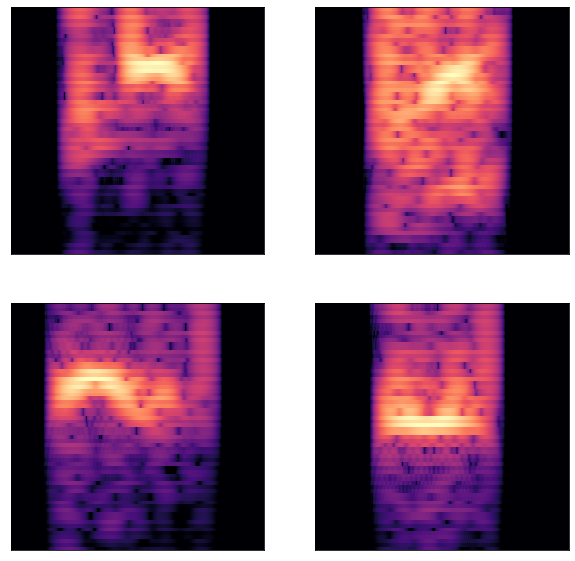

In [5]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)
    y = chop(y, start, dur)
    specshow(y, ax=axs[i])

# Data Augmentation (add noise)

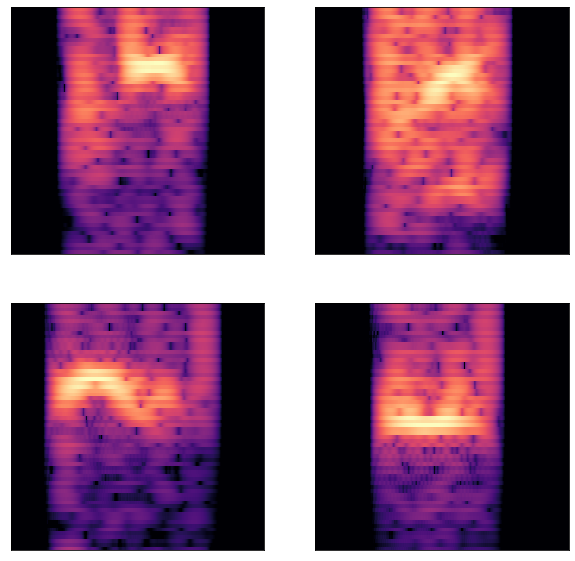

In [6]:
from aug import add_random_noise


f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i in range(4):
    file, phone, start, dur = samples[i]
    spk = file[1:6]
    y, _ = librosa.load(os.path.join(data_root, spk, f'{file}.wav'), sr=16000)
    y = add_random_noise(y, 50)
    y = chop(y, start, dur)
    specshow(y, ax=axs[i], cmap='magma')

# Denoise test

In [7]:
# !pip install denoiser

In [8]:
!mkdir -p denoise_test/input
!cp /NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0139/IC0139W0176.wav denoise_test/input/
!python -m denoiser.enhance --master64 --noisy_dir=denoise_test/input --out_dir=denoise_test/output

/home/tjy/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
INFO:denoiser.pretrained:Loading pre-trained real time H=64 model trained on DNS and Valentini.
INFO:__main__:Generate enhanced files | 1/1 | 0.5 it/sec


## Original vs. Denoised

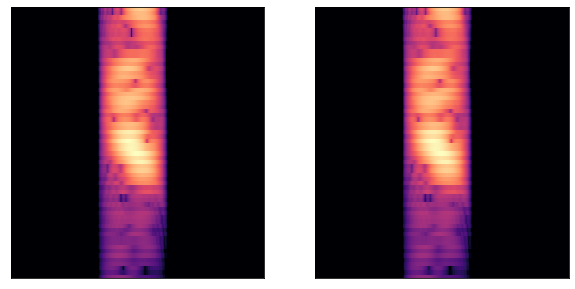

In [9]:
# test file used: ['IC0139W0176', 'ou3', 4.82, 0.08]
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

start, dur = 4.82, 0.08
y, _ = librosa.load('/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0139/IC0139W0176.wav', sr=16000)
y = chop(y, start, dur)
specshow(y, ax=axs[0])

y, _ = librosa.load('denoise_test/output/IC0139W0176_enhanced.wav', sr=16000)
y = chop(y, start, dur)
specshow(y, ax=axs[1])

# Alignment Visualization

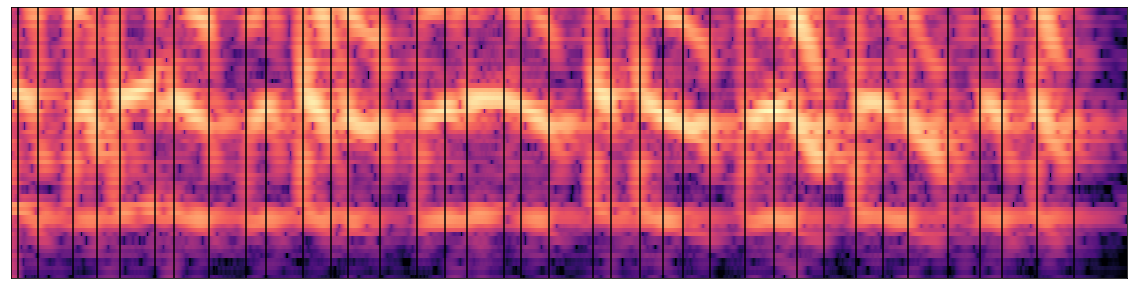

In [10]:
# 二十八个城市的成交量出现了环比增长态势
offset = 0.5
timestamps = [
    0.530,0.610,0.750,0.850,0.940,1.080,1.160,1.300,1.450,1.530,1.680,1.790,
    1.860,1.990,2.140,2.250,2.340,2.490,2.560,2.670,2.850,2.920,3.040,3.130,3.210,3.320,3.460,3.580,
    3.670,3.780,3.910,4.020,4.120,4.280,4.410,4.500,4.640,4.790,
]
timestamps = (np.asarray(timestamps) - offset) * 1000

fig, ax = plt.subplots(figsize=(20, 5))
y, _ = librosa.load('/NASdata/AudioData/mandarin/AISHELL-2/iOS/data/wav/C0053/IC0053W0166.wav', sr=16000)
start, end = librosa.time_to_samples([offset, 5], sr=16000)
y = y[start:end]
specshow(y, ax=ax)

ax.vlines(timestamps, 0, 350)